In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='7'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=4,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-slup15/",
    project_name="breakfast-split-4",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 4, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-slup15/', 'project_name': 'breakfast-split-4', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split4.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split4.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1136
Number of videos not found in train fold is 0
Number of videos logged in test fold is 576
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames

In [12]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
# loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcn-lenpsuedo-full-supervised-split1/ms-tcn-best-model.wt")
# model.load_state_dict(loaded_file)

In [21]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [31]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [24]:
import copy
def change_selected_frames(model):
    global selected_frames_dict
    new_selected_frame_dict = {}
    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)

            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                prior_probs_cur_vid = prior_probs[video_id]
                weakly_labels_masked = []
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    prob_class_masked = prob_class * torch.tensor(prior_probs_cur_vid[i], 
                                                                  dtype=prob_class.dtype, device=prob_class.device)
                    weakly_labels_masked.append(prob_class_masked)
                    
                weakly_labels_masked = torch.stack(weakly_labels_masked)
                weakly_labels_masked = weakly_labels_masked / torch.sum(weakly_labels_masked, dim=0)

                for i in range(len(weakly_labels_video)):
                    cur_l = weakly_labels_video[i]
                    prob_class = weakly_labels_masked[i]
                    expected_value_of_class = torch.argmax(prob_class)
                    new_index_label_pair_list.append((int(expected_value_of_class.item()),
                                                      weakly_labels_video[i])) 
                
                back_list = copy.deepcopy(new_index_label_pair_list)
                error_list = []
                if new_index_label_pair_list[0][0] > new_index_label_pair_list[1][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                for i in range(1, len(new_index_label_pair_list) - 1, 1):
                    err = 0
                    prev_ele = new_index_label_pair_list[i - 1]
                    cur_ele = new_index_label_pair_list[i]
                    next_ele = new_index_label_pair_list[i + 1]
                    if not (prev_ele[0] < cur_ele[0]):
                        err += 1
                    if not (cur_ele[0] < next_ele[0]):
                        err += 1
                    error_list.append(err)

                if new_index_label_pair_list[-1][0] < new_index_label_pair_list[-2][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                    
                if error_list[0] == 1 and error_list[1] == 1:
                    new_index = new_index_label_pair_list[1][0] // 2
                    new_index_label_pair_list[0] = (new_index, new_index_label_pair_list[0][1])
                    error_list[0] = 0
                    error_list[1] = 0
                    
                if error_list[-1] == 1 and error_list[-2] == 1:
                    new_index = (new_index_label_pair_list[-2][0] + weakly_labels_masked.shape[1]) // 2
                    new_index_label_pair_list[-1] = (new_index, new_index_label_pair_list[-1][1])
                    error_list[-1] = 0
                    error_list[-2] = 0
                    
                start_flag = False
                start_index = -1
                end_index = -1
                for i in range(1, len(error_list) - 1):
                    if error_list[i] == 1 and error_list[i + 1] == 2:
                        start_flag = True
                        start_index = i
                        
                    if (start_flag is True) and (error_list[i] == 2 or error_list[i + 1] == 1):
                        start_flag = False
                        end_index = i + 1
                        
                        num_div = end_index - start_index - 1
                        increm = (new_index_label_pair_list[end_index][0] - \
                                  new_index_label_pair_list[start_index][0]) // num_div
                        value = list(range(new_index_label_pair_list[start_index][0], 
                                           new_index_label_pair_list[end_index][0], increm))
                        count = 0
                        for ch_i in range(start_index + 1, end_index):
                            old_ele = new_index_label_pair_list[ch_i]
                            new_ele = (value[count], old_ele[1])
                            new_index_label_pair_list[ch_i] = new_ele
                            count += 1
                    
                final_list = new_index_label_pair_list
                is_valid_list = True
                for i in range(1, len(final_list) - 1, 1):
                    cur_ele = final_list[i]
                    
                    if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
                        is_valid_list  = False

                if is_valid_list == False:
                    print(f"Could not find expected solution for video {video_id}")
                    print(final_list)
                    print(back_list)
                    print(error_list)
                    new_selected_frame_dict[video_id + ".txt"] = selected_frames_dict[video_id + ".txt"]
                else:
                
                    label_name_final_list = []
                    for ele in final_list:
                        label_name_final_list.append((ele[0], label_id_to_label_name[ele[1]]))
                    new_selected_frame_dict[video_id + ".txt"] = label_name_final_list
                
        return new_selected_frame_dict

In [25]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [26]:
# selected_frames_dict = change_selected_frames(model)
# get_new_selected_frame_acc(selected_frames_dict)

In [27]:
# Initialize Expection Boundaries
# print("Calculating Expectation")
# correct = 0.0
# total = 0.0
# model.eval()
# for i, item in enumerate(trainloader):
#     with torch.no_grad():
#         item_0 = item[0].to(device)
#         item_1 = item[1].to(device)
#         item_2 = item[2].to(device)
#         src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
#         src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

#         middle_pred, predictions = model(item_0, src_mask_mse)
#         prob = torch.softmax(predictions[-1], dim=1)
#         prob = prob.permute(0, 2, 1)
#         calculate_element_probb(prob, item_1, item[4])

#         if i % 10 == 0:
#             print(f"Completed iter {i}")

# get_boundary_err()

In [28]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split4-slup15/'

In [32]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0

for epoch in range(25, 150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()
    
    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0)):
        torch.save(model.state_dict(), config.output_dir + f"ms-tcn-initial-{initialize_epoch}-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()



Starting Training
Training:: Epoch 25, Iteration 0, Current loss 3.0428950786590576 Accuracy 61.21641978408235
Training:: Epoch 25, Iteration 10, Current loss 3.110691785812378 Accuracy 65.61863370908597
Training:: Epoch 25, Iteration 20, Current loss 2.4662787914276123 Accuracy 63.68137649316086
Training:: Epoch 25, Iteration 30, Current loss 3.0292460918426514 Accuracy 64.40338379341051
Training:: Epoch 25, Iteration 40, Current loss 2.9688186645507812 Accuracy 62.53463883244042
Training:: Epoch 25, Iteration 50, Current loss 2.638812780380249 Accuracy 58.48197135173701
Training:: Epoch 25, Iteration 60, Current loss 2.882021188735962 Accuracy 69.50900567480879
Training:: Epoch 25, Iteration 70, Current loss 2.7382493019104004 Accuracy 69.90426563257392
Training:: Epoch 25, Iteration 80, Current loss 2.5315325260162354 Accuracy 61.35753945972924
Training:: Epoch 25, Iteration 90, Current loss 3.127528190612793 Accuracy 58.7964039370689
Training:: Epoch 25, Iteration 100, Current loss

Training:: Epoch 29, Iteration 100, Current loss 1.43712967282873 Accuracy 68.59532460409955
Training:: Epoch 29, Iteration 110, Current loss 1.124702450349028 Accuracy 60.402504951024994
Training:: Epoch 29, Iteration 120, Current loss 1.2859740136769586 Accuracy 64.31553504724236
Training:: Epoch 29, Iteration 130, Current loss 1.308723882441427 Accuracy 65.03937657197048
Training:: Epoch 29, Iteration 140, Current loss 1.263368575771478 Accuracy 73.44435418359058
Calculating Validation Data Accuracy
Validation:: Epoch 29, Probability Accuracy 51.86741416610566
Starting Training
Training:: Epoch 30, Iteration 0, Current loss 1.4358938803276415 Accuracy 56.33683016728097
Training:: Epoch 30, Iteration 10, Current loss 1.1769631018549112 Accuracy 70.43090638930164
Training:: Epoch 30, Iteration 20, Current loss 1.5772394463846267 Accuracy 64.17354578613937
Training:: Epoch 30, Iteration 30, Current loss 0.8480536551132928 Accuracy 64.57824789802007
Training:: Epoch 30, Iteration 40, Cu

Training:: Epoch 34, Iteration 40, Current loss 1.417468263047334 Accuracy 62.31616434742465
Training:: Epoch 34, Iteration 50, Current loss 1.0820952587991464 Accuracy 59.27290421242875
Training:: Epoch 34, Iteration 60, Current loss 1.060614377610683 Accuracy 59.97804610318332
Training:: Epoch 34, Iteration 70, Current loss 1.4028008108801113 Accuracy 68.42962777290387
Training:: Epoch 34, Iteration 80, Current loss 2.3918259153571237 Accuracy 53.518167028199564
Training:: Epoch 34, Iteration 90, Current loss 1.415894065834411 Accuracy 65.3848391413113
Training:: Epoch 34, Iteration 100, Current loss 1.002329310936785 Accuracy 63.16372556777716
Training:: Epoch 34, Iteration 110, Current loss 1.0761304204129112 Accuracy 65.39709239456927
Training:: Epoch 34, Iteration 120, Current loss 0.9855358510086375 Accuracy 66.56802947037865
Training:: Epoch 34, Iteration 130, Current loss 0.971359298753274 Accuracy 74.74759020078486
Training:: Epoch 34, Iteration 140, Current loss 1.5700590200

Training:: Epoch 39, Iteration 60, Current loss 0.8092590716074003 Accuracy 61.80832074694494
Training:: Epoch 39, Iteration 70, Current loss 1.1334087595888964 Accuracy 71.73777777777778
Training:: Epoch 39, Iteration 80, Current loss 0.9525849488817899 Accuracy 72.80785608759885
Training:: Epoch 39, Iteration 90, Current loss 1.144666894487013 Accuracy 62.53919388860384
Training:: Epoch 39, Iteration 100, Current loss 1.0747386467180229 Accuracy 74.677867609904
Training:: Epoch 39, Iteration 110, Current loss 0.8897796989291247 Accuracy 72.63603500761035
Training:: Epoch 39, Iteration 120, Current loss 1.1535284811864834 Accuracy 60.61441729634328
Training:: Epoch 39, Iteration 130, Current loss 1.1600160885196453 Accuracy 54.73439917483239
Training:: Epoch 39, Iteration 140, Current loss 0.9302030464280283 Accuracy 66.31226530335249
Calculating Validation Data Accuracy
Validation:: Epoch 39, Probability Accuracy 52.41864325910627
Starting Training
Training:: Epoch 40, Iteration 0, C

Training:: Epoch 44, Iteration 80, Current loss 0.8539614390864158 Accuracy 59.27311598075895
Training:: Epoch 44, Iteration 90, Current loss 0.8757115568661582 Accuracy 70.62956560530864
Training:: Epoch 44, Iteration 100, Current loss 0.7336887353653817 Accuracy 76.78419349344234
Training:: Epoch 44, Iteration 110, Current loss 1.15699139039174 Accuracy 60.42642346561499
Training:: Epoch 44, Iteration 120, Current loss 2.816324909880256 Accuracy 53.69816411519737
Training:: Epoch 44, Iteration 130, Current loss 5.325503915073375 Accuracy 46.52733987929015
Training:: Epoch 44, Iteration 140, Current loss 4.41685271773998 Accuracy 44.77975632614808
Calculating Validation Data Accuracy
Validation:: Epoch 44, Probability Accuracy 45.97946718606004
Starting Training
Training:: Epoch 45, Iteration 0, Current loss 4.804058923498326 Accuracy 44.082840236686394
Training:: Epoch 45, Iteration 10, Current loss 9.531079844647518 Accuracy 34.54411282387668
Training:: Epoch 45, Iteration 20, Curre

Training:: Epoch 49, Iteration 20, Current loss 0.7491543985866588 Accuracy 64.61720049358871
Training:: Epoch 49, Iteration 30, Current loss 0.796497611063592 Accuracy 63.13214827063525
Training:: Epoch 49, Iteration 40, Current loss 0.5724919403039107 Accuracy 73.71950349550578
Training:: Epoch 49, Iteration 50, Current loss 0.7031049282327845 Accuracy 70.0845665961945
Training:: Epoch 49, Iteration 60, Current loss 0.6470882133183676 Accuracy 63.15170060021184
Training:: Epoch 49, Iteration 70, Current loss 0.6895519477560731 Accuracy 50.947184635530334
Training:: Epoch 49, Iteration 80, Current loss 0.65203572058401 Accuracy 56.142674677137045
Training:: Epoch 49, Iteration 90, Current loss 0.6500759440939021 Accuracy 52.846820809248555
Training:: Epoch 49, Iteration 100, Current loss 0.6193738677791725 Accuracy 65.89755011135857
Training:: Epoch 49, Iteration 110, Current loss 2.022705270710021 Accuracy 55.511811023622045
Training:: Epoch 49, Iteration 120, Current loss 1.48290577

Training:: Epoch 54, Iteration 40, Current loss 0.5316116883871388 Accuracy 72.32527893764119
Training:: Epoch 54, Iteration 50, Current loss 0.5429290178343152 Accuracy 73.29768049250669
Training:: Epoch 54, Iteration 60, Current loss 0.5147085458207366 Accuracy 66.04156899515549
Training:: Epoch 54, Iteration 70, Current loss 0.4911080336998107 Accuracy 65.28749259039715
Training:: Epoch 54, Iteration 80, Current loss 0.4783997062626757 Accuracy 73.22202166064982
Training:: Epoch 54, Iteration 90, Current loss 0.6191825938877554 Accuracy 59.44902016472593
Training:: Epoch 54, Iteration 100, Current loss 0.6521096918188644 Accuracy 61.61616161616162
Training:: Epoch 54, Iteration 110, Current loss 0.6345016841213077 Accuracy 65.89285714285714
Training:: Epoch 54, Iteration 120, Current loss 0.5969523365853153 Accuracy 57.56477987421383
Training:: Epoch 54, Iteration 130, Current loss 0.6593557635143587 Accuracy 65.19216085517944
Training:: Epoch 54, Iteration 140, Current loss 0.65299

Training:: Epoch 59, Iteration 60, Current loss 1.7247108153425912 Accuracy 55.101246105919
Training:: Epoch 59, Iteration 70, Current loss 1.044303675975653 Accuracy 60.784109816971714
Training:: Epoch 59, Iteration 80, Current loss 0.8035109493222665 Accuracy 56.539693241193326
Training:: Epoch 59, Iteration 90, Current loss 0.6836758139876776 Accuracy 61.46161064193851
Training:: Epoch 59, Iteration 100, Current loss 0.8240958646665775 Accuracy 57.851912123677785
Training:: Epoch 59, Iteration 110, Current loss 0.7099527335188911 Accuracy 62.854186564788286
Training:: Epoch 59, Iteration 120, Current loss 0.5048591656614896 Accuracy 59.420921815724064
Training:: Epoch 59, Iteration 130, Current loss 0.5059043936193554 Accuracy 71.8111279333838
Training:: Epoch 59, Iteration 140, Current loss 0.7846642171759473 Accuracy 56.537160768786606
Calculating Validation Data Accuracy
Validation:: Epoch 59, Probability Accuracy 51.940698958816725
Starting Training
Training:: Epoch 60, Iteratio

Training:: Epoch 64, Iteration 0, Current loss 0.47990795192220814 Accuracy 65.97018988634044
Training:: Epoch 64, Iteration 10, Current loss 0.37875076357645565 Accuracy 68.33095577746077
Training:: Epoch 64, Iteration 20, Current loss 0.48574786140032433 Accuracy 65.62041874976507
Training:: Epoch 64, Iteration 30, Current loss 0.3862107182419526 Accuracy 61.490345390263805
Training:: Epoch 64, Iteration 40, Current loss 0.4796094711432949 Accuracy 51.96671289875173
Training:: Epoch 64, Iteration 50, Current loss 0.5709959234757618 Accuracy 64.41668345758613
Training:: Epoch 64, Iteration 60, Current loss 0.4679239098175544 Accuracy 70.07676767676767
Training:: Epoch 64, Iteration 70, Current loss 0.4574076300118878 Accuracy 58.72125630959058
Training:: Epoch 64, Iteration 80, Current loss 0.6967878960542433 Accuracy 65.03011498448622
Training:: Epoch 64, Iteration 90, Current loss 0.5214501373410814 Accuracy 59.71563981042654
Training:: Epoch 64, Iteration 100, Current loss 0.370973

Training:: Epoch 69, Iteration 20, Current loss 0.5235570496993173 Accuracy 41.65119117100865
Training:: Epoch 69, Iteration 30, Current loss 0.6341062070689275 Accuracy 55.283674257043614
Training:: Epoch 69, Iteration 40, Current loss 0.4509560634246122 Accuracy 75.0035196395889
Training:: Epoch 69, Iteration 50, Current loss 0.5031266000832625 Accuracy 61.953213322897646
Training:: Epoch 69, Iteration 60, Current loss 0.4690747468285372 Accuracy 66.05575451162137
Training:: Epoch 69, Iteration 70, Current loss 0.5300285208797755 Accuracy 71.09029599100786
Training:: Epoch 69, Iteration 80, Current loss 0.5103530111240686 Accuracy 70.56536803853629
Training:: Epoch 69, Iteration 90, Current loss 0.38128457533775145 Accuracy 65.29086071762421
Training:: Epoch 69, Iteration 100, Current loss 0.4113945977711392 Accuracy 61.34651316979085
Training:: Epoch 69, Iteration 110, Current loss 0.5491627621070096 Accuracy 58.1847934077494
Training:: Epoch 69, Iteration 120, Current loss 0.463797

Training:: Epoch 74, Iteration 40, Current loss 0.7046459849430678 Accuracy 54.08199964035246
Training:: Epoch 74, Iteration 50, Current loss 0.6342403072763964 Accuracy 67.28376777251185
Training:: Epoch 74, Iteration 60, Current loss 0.820435346876057 Accuracy 52.783342873497425
Training:: Epoch 74, Iteration 70, Current loss 0.715709663210116 Accuracy 66.9227764031775
Training:: Epoch 74, Iteration 80, Current loss 0.5423830257212954 Accuracy 66.20218769595206
Training:: Epoch 74, Iteration 90, Current loss 0.7275088205168986 Accuracy 62.75005930260141
Training:: Epoch 74, Iteration 100, Current loss 0.7330680172896564 Accuracy 65.38821328344247
Training:: Epoch 74, Iteration 110, Current loss 0.8086671054512764 Accuracy 51.81327160493827
Training:: Epoch 74, Iteration 120, Current loss 0.7426945069573812 Accuracy 64.22111889351893
Training:: Epoch 74, Iteration 130, Current loss 0.6429250378356602 Accuracy 63.50047641734159
Training:: Epoch 74, Iteration 140, Current loss 1.2806526

Training:: Epoch 78, Iteration 140, Current loss 0.4770534285087831 Accuracy 57.94853842114476
Calculating Validation Data Accuracy
Validation:: Epoch 78, Probability Accuracy 52.44119242609429
Starting Training
Training:: Epoch 79, Iteration 0, Current loss 0.4946840730772616 Accuracy 62.615795258282304
Training:: Epoch 79, Iteration 10, Current loss 0.6370109886262196 Accuracy 50.80507593093405
Training:: Epoch 79, Iteration 20, Current loss 0.41756021659916476 Accuracy 67.24565756823822
Training:: Epoch 79, Iteration 30, Current loss 0.4211838419214195 Accuracy 59.10192997769372
Training:: Epoch 79, Iteration 40, Current loss 0.3812083771187479 Accuracy 65.71279916753382
Training:: Epoch 79, Iteration 50, Current loss 0.37491670632558394 Accuracy 65.38534638411099
Training:: Epoch 79, Iteration 60, Current loss 0.5482284276694446 Accuracy 69.63871643354028
Training:: Epoch 79, Iteration 70, Current loss 0.528742750618454 Accuracy 57.23477973931694
Training:: Epoch 79, Iteration 80, 

Training:: Epoch 84, Iteration 0, Current loss 0.3624364820331095 Accuracy 70.5748822427785
Training:: Epoch 84, Iteration 10, Current loss 0.32312194507533526 Accuracy 61.15307150050352
Training:: Epoch 84, Iteration 20, Current loss 0.4746155782808582 Accuracy 61.22139574548728
Training:: Epoch 84, Iteration 30, Current loss 0.33075196748178126 Accuracy 68.61156131820637
Training:: Epoch 84, Iteration 40, Current loss 0.35529578841294984 Accuracy 63.50587776839644
Training:: Epoch 84, Iteration 50, Current loss 0.40902661789899086 Accuracy 59.14082464258581
Training:: Epoch 84, Iteration 60, Current loss 0.3441218391810903 Accuracy 60.107998650016874
Training:: Epoch 84, Iteration 70, Current loss 0.31640103260776614 Accuracy 61.895595934708965
Training:: Epoch 84, Iteration 80, Current loss 0.5090225910356896 Accuracy 64.05353728489484
Training:: Epoch 84, Iteration 90, Current loss 0.3986112549415498 Accuracy 66.5982263771788
Training:: Epoch 84, Iteration 100, Current loss 0.33373

Training:: Epoch 89, Iteration 20, Current loss 1.618281477283559 Accuracy 68.98098949108514
Training:: Epoch 89, Iteration 30, Current loss 0.7336534233925269 Accuracy 64.03219025884331
Training:: Epoch 89, Iteration 40, Current loss 1.5955529601346259 Accuracy 62.17920516204722
Training:: Epoch 89, Iteration 50, Current loss 1.060890973572632 Accuracy 71.07170846394985
Training:: Epoch 89, Iteration 60, Current loss 1.8829005040027837 Accuracy 47.76372900547273
Training:: Epoch 89, Iteration 70, Current loss 1.0998646363360047 Accuracy 62.330373596917404
Training:: Epoch 89, Iteration 80, Current loss 0.8962214572801216 Accuracy 64.21364646867697
Training:: Epoch 89, Iteration 90, Current loss 1.1713452647556764 Accuracy 62.01133144475921
Training:: Epoch 89, Iteration 100, Current loss 2.484139280432726 Accuracy 58.736
Training:: Epoch 89, Iteration 110, Current loss 1.0191745883565875 Accuracy 60.2487952482349
Training:: Epoch 89, Iteration 120, Current loss 1.0496070960784334 Accu

Training:: Epoch 93, Iteration 120, Current loss 0.2872496389682971 Accuracy 71.2031476496169
Training:: Epoch 93, Iteration 130, Current loss 0.33941905117290005 Accuracy 59.63138816562005
Training:: Epoch 93, Iteration 140, Current loss 0.468205031682407 Accuracy 65.17956725407093
Calculating Validation Data Accuracy
Validation:: Epoch 93, Probability Accuracy 51.923378584173754
Starting Training
Training:: Epoch 94, Iteration 0, Current loss 0.2932045991321948 Accuracy 64.01439050600383
Training:: Epoch 94, Iteration 10, Current loss 0.36991084255686213 Accuracy 62.41052874624798
Training:: Epoch 94, Iteration 20, Current loss 0.3940205475857432 Accuracy 62.901805372082784
Training:: Epoch 94, Iteration 30, Current loss 0.5056056633854902 Accuracy 53.9034716342083
Training:: Epoch 94, Iteration 40, Current loss 0.35791846691894014 Accuracy 65.37706038090357
Training:: Epoch 94, Iteration 50, Current loss 0.3153251472787921 Accuracy 71.79923656246775
Training:: Epoch 94, Iteration 60

Training:: Epoch 98, Iteration 140, Current loss 0.4006468215772878 Accuracy 64.08030860950377
Calculating Validation Data Accuracy
Validation:: Epoch 98, Probability Accuracy 51.80581245629057
Starting Training
Training:: Epoch 99, Iteration 0, Current loss 0.3091787535384496 Accuracy 48.607851072440305
Training:: Epoch 99, Iteration 10, Current loss 0.2659227757267371 Accuracy 69.10815173527038
Training:: Epoch 99, Iteration 20, Current loss 0.3219961733127045 Accuracy 58.94885030502112
Training:: Epoch 99, Iteration 30, Current loss 0.3379089658900077 Accuracy 66.9114334624741
Training:: Epoch 99, Iteration 40, Current loss 0.29942175208993627 Accuracy 69.88261502870363
Training:: Epoch 99, Iteration 50, Current loss 0.24931944659402944 Accuracy 73.63617927398094
Training:: Epoch 99, Iteration 60, Current loss 0.21380909848162502 Accuracy 67.2777431698852
Training:: Epoch 99, Iteration 70, Current loss 0.3311006345906243 Accuracy 52.09861695730607
Training:: Epoch 99, Iteration 80, 

Calculating Validation Data Accuracy
Validation:: Epoch 103, Probability Accuracy 51.38056457885346
Starting Training
Training:: Epoch 104, Iteration 0, Current loss 0.34018720819684367 Accuracy 59.168241965973536
Training:: Epoch 104, Iteration 10, Current loss 0.3305948031319344 Accuracy 54.8512709572742
Training:: Epoch 104, Iteration 20, Current loss 0.32062776966644013 Accuracy 59.147914791479145
Training:: Epoch 104, Iteration 30, Current loss 0.27982600228828436 Accuracy 62.230570556468656
Training:: Epoch 104, Iteration 40, Current loss 0.2793317868428582 Accuracy 49.96012304887775
Training:: Epoch 104, Iteration 50, Current loss 0.4324975562561765 Accuracy 55.34639128115235
Training:: Epoch 104, Iteration 60, Current loss 0.3755620770823356 Accuracy 60.8116848119004
Training:: Epoch 104, Iteration 70, Current loss 0.3742321174980743 Accuracy 68.27236128128828
Training:: Epoch 104, Iteration 80, Current loss 0.3400820186285599 Accuracy 59.19954833448341
Training:: Epoch 104, It

Training:: Epoch 108, Iteration 80, Current loss 0.6918528231285184 Accuracy 55.52756555853809
Training:: Epoch 108, Iteration 90, Current loss 0.38356161051533966 Accuracy 75.40121748754842
Training:: Epoch 108, Iteration 100, Current loss 0.4781920645338512 Accuracy 59.93318275926971
Training:: Epoch 108, Iteration 110, Current loss 0.6324900105102367 Accuracy 53.230275630742305
Training:: Epoch 108, Iteration 120, Current loss 0.4732539226468045 Accuracy 59.37427978796958
Training:: Epoch 108, Iteration 130, Current loss 0.265072419751438 Accuracy 71.7035000528709
Training:: Epoch 108, Iteration 140, Current loss 0.43796580221248294 Accuracy 78.65546218487395
Calculating Validation Data Accuracy
Validation:: Epoch 108, Probability Accuracy 53.17453055248727
Starting Training
Training:: Epoch 109, Iteration 0, Current loss 0.42365094878837234 Accuracy 56.27332564293954
Training:: Epoch 109, Iteration 10, Current loss 0.4549025929552956 Accuracy 69.95176768932426
Training:: Epoch 109,

Training:: Epoch 113, Iteration 90, Current loss 0.331359183011423 Accuracy 66.41436131020163
Training:: Epoch 113, Iteration 100, Current loss 0.5049643435481961 Accuracy 61.93951248871502
Training:: Epoch 113, Iteration 110, Current loss 0.48838261018745344 Accuracy 65.38442810537079
Training:: Epoch 113, Iteration 120, Current loss 0.29844151080160464 Accuracy 60.5633215105362
Training:: Epoch 113, Iteration 130, Current loss 0.2327651417791731 Accuracy 69.11664226451927
Training:: Epoch 113, Iteration 140, Current loss 0.3577736182806265 Accuracy 68.11155212032588
Calculating Validation Data Accuracy
Validation:: Epoch 113, Probability Accuracy 53.1514911862169
Starting Training
Training:: Epoch 114, Iteration 0, Current loss 0.40369622248747805 Accuracy 59.75103734439834
Training:: Epoch 114, Iteration 10, Current loss 0.252186035917484 Accuracy 60.63001080343435
Training:: Epoch 114, Iteration 20, Current loss 0.45344587376641116 Accuracy 49.062605426767554
Training:: Epoch 114, 

Training:: Epoch 118, Iteration 100, Current loss 0.3216775244169544 Accuracy 64.42506568282185
Training:: Epoch 118, Iteration 110, Current loss 0.31141016347344025 Accuracy 56.458871971655654
Training:: Epoch 118, Iteration 120, Current loss 0.33879583238814903 Accuracy 53.162708477442166
Training:: Epoch 118, Iteration 130, Current loss 0.31178811805082535 Accuracy 66.44954455244007
Training:: Epoch 118, Iteration 140, Current loss 0.3564444916640341 Accuracy 57.261822904729165
Calculating Validation Data Accuracy
Validation:: Epoch 118, Probability Accuracy 53.09511826874685
Starting Training
Training:: Epoch 119, Iteration 0, Current loss 0.2997063197275309 Accuracy 65.81984566004235
Training:: Epoch 119, Iteration 10, Current loss 0.23342120901473962 Accuracy 64.7940074906367
Training:: Epoch 119, Iteration 20, Current loss 0.2610383874113223 Accuracy 67.81794980859209
Training:: Epoch 119, Iteration 30, Current loss 0.2589096053876222 Accuracy 67.71839356727702
Training:: Epoch 

Training:: Epoch 123, Iteration 30, Current loss 0.4578019353677565 Accuracy 64.60176991150442
Training:: Epoch 123, Iteration 40, Current loss 0.49441214662424177 Accuracy 72.07018318252041
Training:: Epoch 123, Iteration 50, Current loss 0.660570120032757 Accuracy 58.86407912483141
Training:: Epoch 123, Iteration 60, Current loss 0.30377675723113 Accuracy 72.13437590501013
Training:: Epoch 123, Iteration 70, Current loss 0.3875562016892188 Accuracy 61.869253601679574
Training:: Epoch 123, Iteration 80, Current loss 0.5501961735688352 Accuracy 60.82503355230628
Training:: Epoch 123, Iteration 90, Current loss 0.4033298319895361 Accuracy 59.679015837104075
Training:: Epoch 123, Iteration 100, Current loss 0.5361009691253212 Accuracy 64.75710748740715
Training:: Epoch 123, Iteration 110, Current loss 0.3892304327088991 Accuracy 66.2253183244141
Training:: Epoch 123, Iteration 120, Current loss 0.3480294530051366 Accuracy 50.08771433421991
Training:: Epoch 123, Iteration 130, Current los

Training:: Epoch 128, Iteration 40, Current loss 0.28393731155213686 Accuracy 60.86927845930616
Training:: Epoch 128, Iteration 50, Current loss 0.22650679210806812 Accuracy 66.54442209866319
Training:: Epoch 128, Iteration 60, Current loss 0.2607433163691399 Accuracy 61.524155137219324
Training:: Epoch 128, Iteration 70, Current loss 0.23637249119473686 Accuracy 72.18487977271153
Training:: Epoch 128, Iteration 80, Current loss 0.3485084466623647 Accuracy 52.82165368928439
Training:: Epoch 128, Iteration 90, Current loss 0.20595799140584395 Accuracy 67.39788199697428
Training:: Epoch 128, Iteration 100, Current loss 0.22182023093502476 Accuracy 72.39450940518556
Training:: Epoch 128, Iteration 110, Current loss 0.4783390625068689 Accuracy 71.37530819652414
Training:: Epoch 128, Iteration 120, Current loss 0.17531933542419936 Accuracy 63.34653159870417
Training:: Epoch 128, Iteration 130, Current loss 0.2564299754972214 Accuracy 69.4698485281509
Training:: Epoch 128, Iteration 140, Cur

Training:: Epoch 133, Iteration 50, Current loss 0.21141394882008693 Accuracy 57.985339848956016
Training:: Epoch 133, Iteration 60, Current loss 0.1883705769155963 Accuracy 72.02450058048761
Training:: Epoch 133, Iteration 70, Current loss 0.2082813394136704 Accuracy 56.88700918964077
Training:: Epoch 133, Iteration 80, Current loss 0.24121537249823935 Accuracy 64.9319022278344
Training:: Epoch 133, Iteration 90, Current loss 0.19338715251874808 Accuracy 55.03366817529529
Training:: Epoch 133, Iteration 100, Current loss 0.24668024275023848 Accuracy 51.635883905013195
Training:: Epoch 133, Iteration 110, Current loss 0.24408442996201182 Accuracy 52.299790928097444
Training:: Epoch 133, Iteration 120, Current loss 0.36969954213908524 Accuracy 58.07782418254049
Training:: Epoch 133, Iteration 130, Current loss 0.3213811248958726 Accuracy 70.16301100964411
Training:: Epoch 133, Iteration 140, Current loss 0.33373768878601906 Accuracy 60.87178613996254
Calculating Validation Data Accuracy

Training:: Epoch 137, Iteration 140, Current loss 0.20839558098819885 Accuracy 70.39541547277938
Calculating Validation Data Accuracy
Validation:: Epoch 137, Probability Accuracy 52.71987071810927
Starting Training
Training:: Epoch 138, Iteration 0, Current loss 0.26389216192077924 Accuracy 61.29011511994341
Training:: Epoch 138, Iteration 10, Current loss 0.23960271053204732 Accuracy 73.20341047503045
Training:: Epoch 138, Iteration 20, Current loss 0.2065446496921826 Accuracy 61.66967509025271
Training:: Epoch 138, Iteration 30, Current loss 0.2391201826032384 Accuracy 67.64060213255279
Training:: Epoch 138, Iteration 40, Current loss 0.23661470921180355 Accuracy 62.413923571698824
Training:: Epoch 138, Iteration 50, Current loss 0.18096399949976588 Accuracy 71.23222100656456
Training:: Epoch 138, Iteration 60, Current loss 0.2540848190052297 Accuracy 64.96887124424795
Training:: Epoch 138, Iteration 70, Current loss 0.1822595294647808 Accuracy 72.79137529137529
Training:: Epoch 138,

Training:: Epoch 143, Iteration 90, Current loss 4.626537559327595 Accuracy 55.665248226950354
Training:: Epoch 143, Iteration 100, Current loss 5.569461023718995 Accuracy 35.29340150961772
Training:: Epoch 143, Iteration 110, Current loss 2.129641062238322 Accuracy 53.45506419400856
Training:: Epoch 143, Iteration 120, Current loss 2.950692219464929 Accuracy 49.358727362800686
Training:: Epoch 143, Iteration 130, Current loss 1.292532427271698 Accuracy 64.47934757985351
Training:: Epoch 143, Iteration 140, Current loss 0.8989352965106805 Accuracy 66.90417690417691
Calculating Validation Data Accuracy
Validation:: Epoch 143, Probability Accuracy 52.79495290818894
Starting Training
Training:: Epoch 144, Iteration 0, Current loss 1.0617888351501636 Accuracy 56.68280992560787
Training:: Epoch 144, Iteration 10, Current loss 0.7959425897177992 Accuracy 58.366654549860655
Training:: Epoch 144, Iteration 20, Current loss 0.7312188409567602 Accuracy 58.966171901967556
Training:: Epoch 144, It

Training:: Epoch 148, Iteration 100, Current loss 0.2747047504115696 Accuracy 67.22272317403066
Training:: Epoch 148, Iteration 110, Current loss 0.2771530538507485 Accuracy 57.511080009330534
Training:: Epoch 148, Iteration 120, Current loss 0.18389523128845364 Accuracy 68.70823033965029
Training:: Epoch 148, Iteration 130, Current loss 0.3223961373414184 Accuracy 64.05144694533762
Training:: Epoch 148, Iteration 140, Current loss 0.24641498754189123 Accuracy 62.44258872651357
Calculating Validation Data Accuracy
Validation:: Epoch 148, Probability Accuracy 52.87199589539801
Starting Training
Training:: Epoch 149, Iteration 0, Current loss 0.21537164517578924 Accuracy 62.26166773529511
Training:: Epoch 149, Iteration 10, Current loss 0.2341540609870178 Accuracy 60.49213161659514
Training:: Epoch 149, Iteration 20, Current loss 0.15712084789323885 Accuracy 63.35321918338886
Training:: Epoch 149, Iteration 30, Current loss 0.1838801748945153 Accuracy 75.54215399610136
Training:: Epoch 1

In [32]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 130, Probability Accuracy 51.43919338691232


In [33]:
best_val_acc

54.61000906173455

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

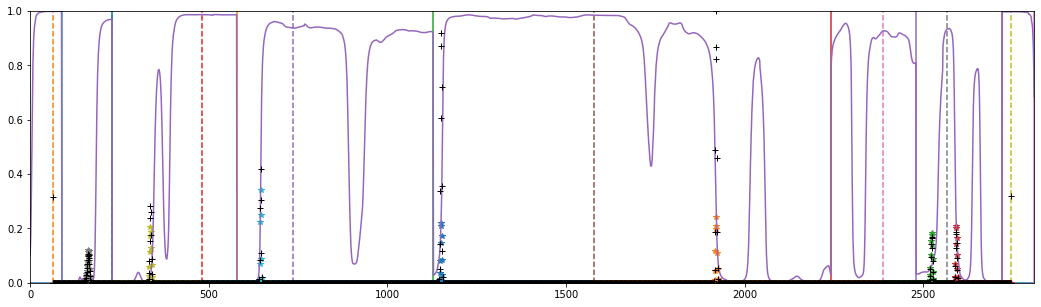

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

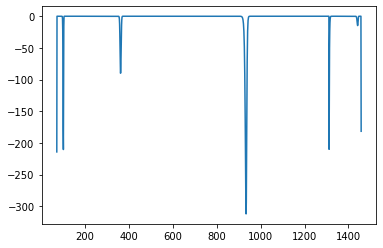

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

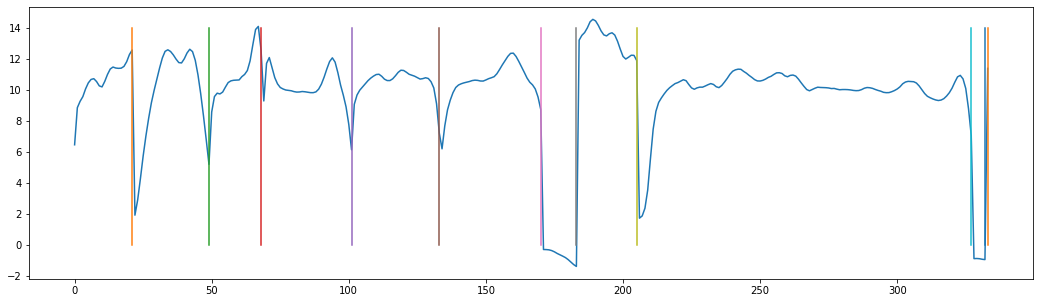

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])